In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from biom import load_table
import matplotlib.pyplot as plt
import seaborn as sns
#from gneiss.util import match
from scipy.spatial import KDTree
from scipy.stats import rankdata
from skbio.stats.composition import clr, clr_inv, centralize
from sklearn.neighbors import NearestNeighbors, KDTree
from skbio.stats.ordination import OrdinationResults
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr
from src.evaluate import _edge_roc_curve


from matplotlib import rc
import matplotlib
%matplotlib inline

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


# Evaluate True Positive rate of methods

Since we have annotations, we should be able to do this.

In [5]:
tools = ['mmvec', 'spearman', 'pearson', 'sparcc', 'phi', 'rho', 'spiec-easi']
fnames = [
    'mmvec_ranks.csv',
    'soils_spearman.txt',    
    'soils_pearson.txt',
    'cor_matrix_soil_SparCC.csv',
    'prop_matrix_soil_PHI.csv',
    'prop_matrix_soil_RHO.csv',
    'weights_soil_SPIECEASI.csv'    
]

In [6]:
!ls ../results/soil_output

TP.png                        prop_matrix_soil_RHO.csv
cor_matrix_soil_SparCC.csv    soils_pearson.txt
edgelist_soil_SEmultitest.csv soils_spearman.txt
mmvec_ranks.csv               weights_soil_SPIECEASI.csv
prop_matrix_soil_PHI.csv


In [7]:
select_microbes = ['rplo 1 (Cyanobacteria)', 'rplo 2 (Firmicutes)', 
                   'rplo 60 (Firmicutes)', 'rplo 7 (Actinobacteria)']
microcoleus_metabolites = ['(3-methyladenine)', '7-methyladenine', '4-guanidinobutanoate', 'uracil',
                           'xanthine', 'hypoxanthine', '(N6-acetyl-lysine)', 'cytosine',
                           'N-acetylornithine', 'N-acetylornithine', 'succinate', 
                           'adenosine', 'guanine', 'adenine']

In [8]:
ranks = pd.read_csv(os.path.join('../results/soil_output', fnames[0]), index_col=0)

In [9]:
sensitivity = lambda x: x['TP'] / (x['TP'] + x['FN'])
specificity = lambda x: x['TN'] / (x['TN'] + x['FP'])
precision = lambda x: x['TP'] / (x['TP'] + x['FP'])
recall = lambda x: x['TP'] / (x['TP'] + x['FN'])
f1 = lambda x: 2 * x['precision'] * x['recall'] / (x['precision'] + x['recall'])

In [10]:
edges = pd.DataFrame(list(zip(['rplo 1 (Cyanobacteria)'] * len(microcoleus_metabolites), 
                     microcoleus_metabolites)), columns=['microbe', 'metabolite'])
edges['direction'] = 'R'

microbes = list(ranks.columns)
metabolites = list(ranks.columns)
other_metabolites = list(set(metabolites) - set(microcoleus_metabolites))

other_edges = pd.DataFrame(other_metabolites, columns=['metabolite'])
other_edges['microbe'] = 'rplo 1 (Cyanobacteria)'
other_edges['direction'] = 0

edges = pd.concat((edges, other_edges), axis=0)
edges = edges[['microbe', 'metabolite', 'direction']]

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [11]:
def read_df(fname):
    if '.txt' in fname:
        return pd.read_table(os.path.join('../results/soil_output', fname), 
                                          index_col=0)
    else:
        return pd.read_csv(os.path.join('../results/soil_output', fname), 
                                        index_col=0)
    
rankz = list(map(read_df, fnames))

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


In [16]:
def roc_f(ranks, tool):
    r = ranks.T[['rplo 1 (Cyanobacteria)']].loc[metabolites].T
    if tool == 'phi':
        r = 1 / r
        
    res = _edge_roc_curve(r, edges, k_max=40)
    return res
rocs = list(map(lambda x: roc_f(x[0], x[1]), zip(rankz, tools)))

In [17]:
for res in rocs:
    for df in res:
        df['TPR'] = df.apply(sensitivity, axis=1)
        df['TNR'] = df.apply(specificity, axis=1)
        df['precision'] = df.apply(precision, axis=1)
        df['recall'] = df.apply(recall, axis=1)
        df['f1_score'] = df.apply(f1, axis=1)

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in long_scalars
  """Entry point for launching an IPython kernel.
/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


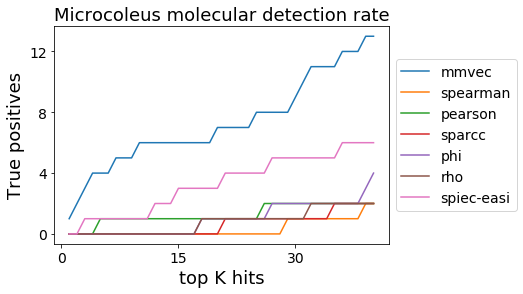

In [32]:
fig, ax = plt.subplots(figsize=(6, 4))
#plt.subplots_adjust(wspace=0.4, hspace=0.5)

for tool, roc in zip(tools, rocs):
    ax.plot(roc[0]['TP'], label=tool)            
    ax.set_ylabel('True positives', fontsize=18)
    ax.set_xlabel('top K hits', fontsize=18)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))      

ax.set_title('Microcoleus molecular detection rate', fontsize=18)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

# Construct plot of spearman coefficients vs conditional probabilities


In [19]:
microbes = load_table('../data/soils/microbes.biom')
metabolites = load_table('../data/soils/metabolites.biom')
microbes = microbes.to_dataframe().T
metabolites = metabolites.to_dataframe().T

microbes, metabolites = microbes.align(metabolites, join='inner', axis=0)
# cmicrobes = microbes.apply(lambda x: x / x.sum(), axis=1)
# cmetabolites = metabolites.apply(lambda x: x / x.sum(), axis=1)

In [20]:
microbes.shape, metabolites.shape

((19, 466), (19, 85))

In [21]:
len(microbes.columns), len(metabolites.columns)

(466, 85)

In [26]:
# align axes
coefs = rankz[0]          # mmvec
spearman_coefs = rankz[1] # spearman
coefs, spearman_coefs = coefs.align(spearman_coefs, join='inner', axis=0)

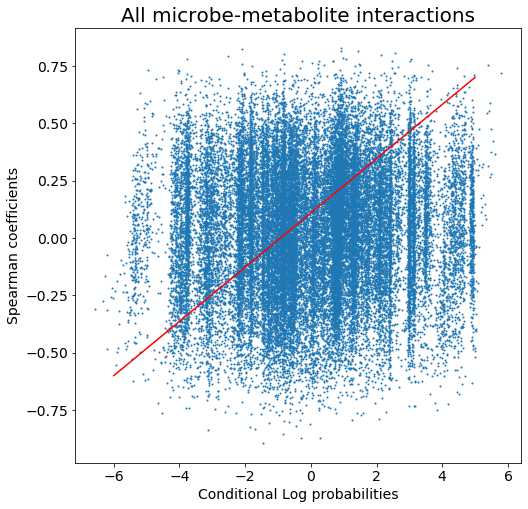

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(coefs.values.ravel(), spearman_coefs.values.ravel(), s=1)
ax.set_xlabel('Conditional Log probabilities', fontsize=14) 
ax.set_ylabel('Spearman coefficients', fontsize=14)

labelsize = 14
ax.tick_params(axis="x", labelsize=labelsize)
ax.tick_params(axis="y", labelsize=labelsize)
ax.plot(np.linspace(-6, 5), np.linspace(-.6, 0.7), '-r')

ax.set_title('All microbe-metabolite interactions', fontsize=20)

In [23]:
dxdy = pd.DataFrame(
    {
        '(3-methyladenine)': (-0., -0.15),
        '7-methyladenine': (0.7, -0),
        '4-guanidinobutanoate': (-1.9, -0.2),
        'uracil': (0.6, -0.1),
        'xanthine': (0, 0.1),
        'hypoxanthine': (0.2, -0.2),
        '(N6-acetyl-lysine)': (-1.7, 0.1),
        'cytosine': (0, 0.1),
        'N-acetylornithine': (0.2, 0.1),
        'succinate': (-0.5, 0.2),
        'adenosine': (-1.2, 0.1),
        'guanine': (0.4, -0.2),
        'adenine': (-0.7, -0.2)
    }, index=['dx', 'dy']
).T

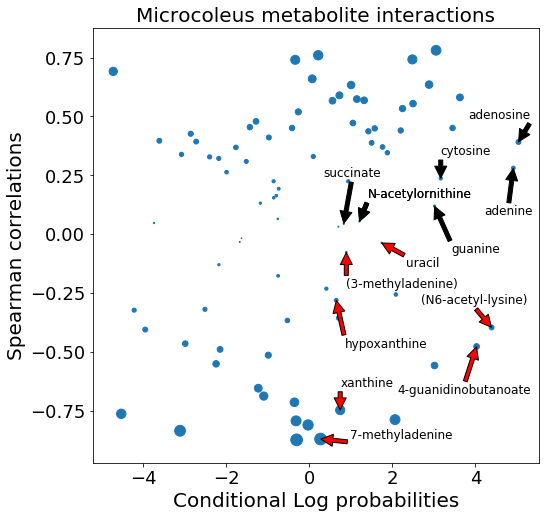

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))
i = select_microbes[0]
ax.scatter(coefs.loc[i].values.ravel(), 
           spearman_coefs.loc[i].values.ravel(),             
           s=-10*np.log(spearman_pvals.loc[i].values.ravel().astype(np.float32)),
           label=i)

for j in microcoleus_metabolites:    
    dx = dxdy.loc[j, 'dx']
    dy = dxdy.loc[j, 'dy']
    
    x = coefs.loc[i, j]
    y = spearman_coefs.loc[i, j]
    if j in ['(3-methyladenine)', '7-methyladenine', '4-guanidinobutanoate', 'uracil',
             'xanthine', 'hypoxanthine', '(N6-acetyl-lysine)']:
        ax.annotate(j, xy=(x, y), xytext=(x+dx, y+dy), fontsize=12,
                    arrowprops=dict(facecolor='red', shrink=0.01))
    else:
        ax.annotate(j, xy=(x, y), xytext=(x+dx, y+dy), fontsize=12,
                    arrowprops=dict(facecolor='black', shrink=0.01))

ax.set_xlabel('Conditional Log probabilities', fontsize=20)
ax.set_ylabel('Spearman correlations', fontsize=20)
#ax.legend(loc=2, fontsize=12)
labelsize = 18
ax.tick_params(axis="x", labelsize=labelsize)
ax.tick_params(axis="y", labelsize=labelsize)
#ax.plot(np.linspace(-6, 4), np.linspace(-.6, 0.6), '-r')

#ax.set_title(r'$\textit{Microcoleus}$ metabolite interactions', fontsize=20)
ax.set_title(r'Microcoleus metabolite interactions', fontsize=20)

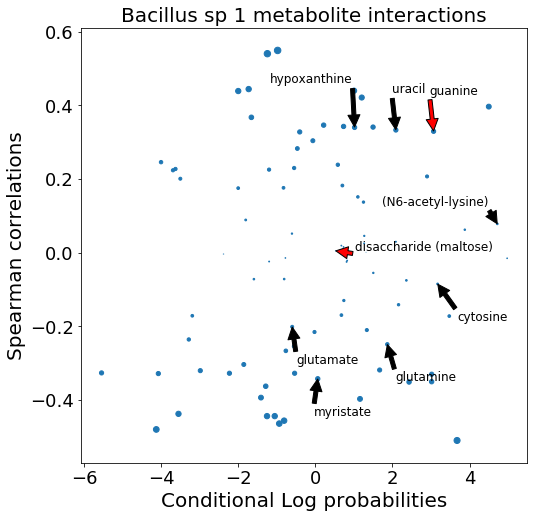

In [30]:
bacillus_1_metabolites = ['uracil', 'hypoxanthine', '(N6-acetyl-lysine)', 'cytosine',
                          'guanine', 'disaccharide (maltose)', 'glutamine', 
                          'myristate', 'glutamate']

dxdy = pd.DataFrame(
    {
        'uracil': (-.1, .1), 
        'hypoxanthine': (-2.2, 0.12), 
        '(N6-acetyl-lysine)': (-3.0, 0.05), 
        'cytosine': (.5, -.1),
        'guanine': (-.1, .1), 
        'adenine': (-1.2, -.15), 
        'disaccharide (maltose)': (.5, 0), 
        'glutamine': (.2, -.1), 
        'myristate': (-.1, -.1), 
        'glutamate': (0.1, -0.1)
    }, index=['dx', 'dy']
).T

fig, ax = plt.subplots(figsize=(8, 8))
i = select_microbes[1]
ax.scatter(coefs.loc[i].values.ravel(), 
           spearman_coefs.loc[i].values.ravel(), 
           s=-10*np.log(spearman_pvals.loc[i].values.ravel().astype(np.float32)),
           label=i)

for j in bacillus_1_metabolites:    
    dx = dxdy.loc[j, 'dx']
    dy = dxdy.loc[j, 'dy']
    
    x = coefs.loc[i, j]
    y = spearman_coefs.loc[i, j]
    if j in ['guanine', 'disaccharide (maltose)']:
        ax.annotate(j, xy=(x, y), xytext=(x+dx, y+dy), fontsize=12,
                    arrowprops=dict(facecolor='red', shrink=0.01))
    else:
        ax.annotate(j, xy=(x, y), xytext=(x+dx, y+dy), fontsize=12,
                    arrowprops=dict(facecolor='black', shrink=0.01))

ax.set_xlabel('Conditional Log probabilities', fontsize=20)
ax.set_ylabel('Spearman correlations', fontsize=20)
#ax.legend(loc=2, fontsize=12)
labelsize = 18
ax.tick_params(axis="x", labelsize=labelsize)
ax.tick_params(axis="y", labelsize=labelsize)
#ax.plot(np.linspace(-6, 4), np.linspace(-.6, 0.6), '-r')

#ax.set_title(r'$\textit{Bacillus sp 1}\; $ metabolite interactions', fontsize=20)
ax.set_title(r'Bacillus sp 1 metabolite interactions', fontsize=20)

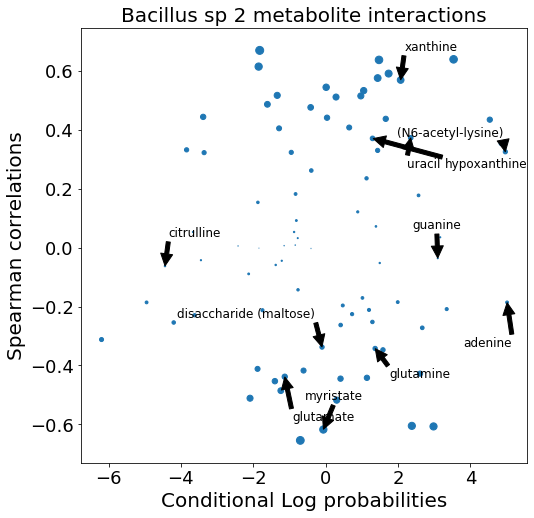

In [33]:
bacillus_2_metabolites = ['uracil', 'hypoxanthine', '(N6-acetyl-lysine)',
                          'guanine', 'adenine', 'disaccharide (maltose)', 'glutamine', 
                          'myristate', 'glutamate', 'xanthine', 'citrulline']

dxdy = pd.DataFrame(
    {
        'uracil': (-.1, -.1), 
        'hypoxanthine': (2., -0.1), 
        '(N6-acetyl-lysine)': (-3.0, 0.05), 
        'cytosine': (0.1, -.1),
        'guanine': (-.7, .1), 
        'adenine': (-1.2, -.15), 
        'disaccharide (maltose)': (-4., 0.1), 
        'glutamine': (.4, -.1), 
        'myristate': (-.5, .1), 
        'glutamate': (0.2, -0.15),
        'xanthine': (0.1, 0.1), 
        'citrulline': (0.1, 0.1)
    }, index=['dx', 'dy']
).T

fig, ax = plt.subplots(figsize=(8, 8))
i = select_microbes[2]
ax.scatter(coefs.loc[i].values.ravel(), 
           spearman_coefs.loc[i].values.ravel(), 
           s=-10*np.log(spearman_pvals.loc[i].values.ravel().astype(np.float32)),
           label=i)

for j in bacillus_2_metabolites:    
    dx = dxdy.loc[j, 'dx']
    dy = dxdy.loc[j, 'dy']
    
    x = coefs.loc[i, j]
    y = spearman_coefs.loc[i, j]
    ax.annotate(j, xy=(x, y), xytext=(x+dx, y+dy), fontsize=12,
                arrowprops=dict(facecolor='black', shrink=0.01))

ax.set_xlabel('Conditional Log probabilities', fontsize=20)
ax.set_ylabel('Spearman correlations', fontsize=20)
#ax.legend(loc=2, fontsize=12)
labelsize = 18
ax.tick_params(axis="x", labelsize=labelsize)
ax.tick_params(axis="y", labelsize=labelsize)
#ax.plot(np.linspace(-6, 4), np.linspace(-.6, 0.6), '-r')
#ax.set_title(r'$\textit{Bacillus sp 2}\; $ metabolite interactions', fontsize=20)
ax.set_title(r'Bacillus sp 2 metabolite interactions', fontsize=20)

#TODO: Make 1 big subplot all of the plots

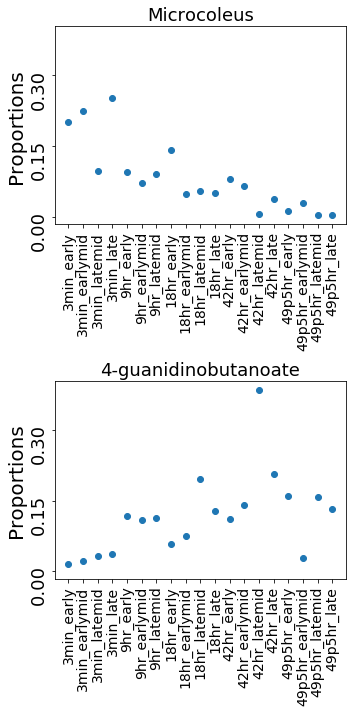

In [41]:
import matplotlib.ticker as ticker

cmicrobes = microbes.apply(lambda x: x / x.sum(), axis=1)
cmetabolites = metabolites.apply(lambda x: x / x.sum(), axis=1)

rc('text', usetex=False)
fig, ax = plt.subplots(2, 1, figsize=(5, 10), sharey=True)
ax[0].plot(np.array(cmicrobes['rplo 1 (Cyanobacteria)'].values),
         marker='o', linestyle='',label='Microcoleus')
ax[0].set_xticks(np.arange(len(cmicrobes.index)))
ax[0].set_xticklabels(list(cmicrobes.index))

ax[1].plot(np.array(cmetabolites['4-guanidinobutanoate'].values), 
         marker='o', linestyle='', label='4-guanidinobutanoate')
ax[1].set_xticks(np.arange(len(cmetabolites.index)))
ax[1].set_xticklabels(list(cmetabolites.index))
#ax[0].set_xticks([])

ax[0].tick_params(axis='x', rotation=90, labelsize=14)
ax[0].tick_params(axis='y', rotation=90, labelsize=18)
ax[1].tick_params(axis='x', rotation=90, labelsize=14)
ax[1].tick_params(axis='y', rotation=90, labelsize=18)

ax[0].yaxis.set_major_locator(ticker.MaxNLocator(4))
ax[1].yaxis.set_major_locator(ticker.MaxNLocator(4))

ax[0].set_ylabel('Proportions', fontsize=20)
ax[1].set_ylabel('Proportions', fontsize=20)


ax[0].set_title('Microcoleus', fontsize=18)
ax[1].set_title('4-guanidinobutanoate', fontsize=18)

#ax[0].legend()
plt.tight_layout()